In [1]:
import pdb
import numpy as np
import pandas as pd
import os
import pylab as plt
from utils import clean_args
from utils import clean_nans
from utils import fast_sed
from utils import fast_sed_fitter
from utils import fast_Lir
from utils import stagger_x
from utils import subset_averages_from_ids
from utils import main_sequence_s15
from skymaps import Field_catalogs
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
try:
    from simstack import PickledStacksReader, measure_cib
except:
    from simstack.simstack import PickledStacksReader, measure_cib

%matplotlib inline  

In [2]:
conv_luv_to_sfr = 2.17e-10
conv_lir_to_sfr = 1.72e-10
L_sun = 3.839e26 # W
c = 299792458.0 # m/s
a_nu_flux_to_mass = 6.7e19
h = 6.62607004e-34 #m2 kg / s  #4.13e-15 #eV/s
k = 1.38064852e-23 #m2 kg s-2 K-1 8.617e-5 #eV/K

In [3]:
popcolor=['red','blue','green','orange','black','grey','chocolate','darkviolet','pink','magenta','dodgerblue','lavender','blue','red','green','orange','black','grey','chocolate','darkviolet','pink','magenta','dodgerblue','lavender']

In [4]:
path_pickles = os.environ['PICKLESPATH']
path_maps    = os.environ['MAPSPATH']
path_catalogs= os.environ['CATSPATH']

In [5]:
#Location of the stacked parameter file
shortname = 'uVista_Laigle_v1.1__2pop__7bands__s15_bins_in_slices'
path_config = path_pickles + '/simstack/stacked_flux_densities/simstack_fluxes/'+shortname+'/'
file_config = 'uvista__DR2__2pop__7_maps_s15_binning.cfg'
if os.path.exists(path_config+file_config) == True:
    path_config+file_config

In [6]:
stacked_flux_densities = PickledStacksReader(path_config,file_config)

sf
red


In [7]:
stacked_flux_densities.params['bins']

{'bin_in_lookback_time': False,
 'bin_in_number_density': False,
 'm_nodes': [9.5, 10.0, 10.5, 11.0, 11.5],
 'optimal_binning': False,
 'stack_all_z_at_once': False,
 't_nodes': [0.3, 0.7, 1.2, 1.8, 2.5, 3.5, 5.0],
 'z_nodes': [0.3, 0.7, 1.2, 1.8, 2.5, 3.5, 5.0]}

In [8]:
measure_cib(stacked_flux_densities,tcib = True)#, area_deg= 1.4*1.4)

defaulting to uVista/COSMOS area of 1.62deg2


array([ 1.58966796,  5.01373351,  6.73677512,  7.04892813,  4.47023368,
        1.87612044,  0.18977072])

In [9]:
#Location of the bootstrap parameter file
shortname = 'uVista_Laigle_v1.1__2pop__7bands__s15_bins_in_slices'
path_config = path_pickles + 'simstack/stacked_flux_densities/bootstrapped_fluxes/'+shortname+'/'
file_config = 'uvista__DR2__2pop__7_maps_s15_binning.cfg' 
if os.path.exists(path_config+file_config) == True:
    print path_config+file_config

/data/pickles/simstack/stacked_flux_densities/bootstrapped_fluxes/uVista_Laigle_v1.1__2pop__7bands__s15_bins_in_slices/uvista__DR2__2pop__7_maps_s15_binning.cfg


In [10]:
boot_errs = PickledStacksReader(path_config,file_config)

sf
red


In [11]:
np.shape(boot_errs.boot_error_bars)

(7, 6, 4, 2)

In [12]:
boot_errs.params['bins']

{'bin_in_lookback_time': False,
 'bin_in_number_density': False,
 'm_nodes': [9.5, 10.0, 10.5, 11.0, 11.5],
 'optimal_binning': False,
 'stack_all_z_at_once': False,
 't_nodes': [0.3, 0.7, 1.2, 1.8, 2.5, 3.5, 5.0],
 'z_nodes': [0.3, 0.7, 1.2, 1.8, 2.5, 3.5, 5.0]}

In [13]:
print boot_errs.params['bins']['z_nodes']
print boot_errs.params['number_of_boots']

[0.3, 0.7, 1.2, 1.8, 2.5, 3.5, 5.0]
10.0


In [14]:
wvs = stacked_flux_densities.wvs
m_nodes = np.array(stacked_flux_densities.m_nodes)
z_nodes = np.array(stacked_flux_densities.z_nodes)
z_mid = (z_nodes[1:]+z_nodes[:-1])/2.
m_mid = (m_nodes[1:]+m_nodes[:-1])/2.
nwv = len(wvs)
nz = stacked_flux_densities.nz
nm = stacked_flux_densities.nm
npop =  stacked_flux_densities.npops
pop = stacked_flux_densities.pops
all_stacked_fluxes = stacked_flux_densities.simstack_flux_array
boot_norm = clean_nans(np.mean(boot_errs.bootstrap_flux_array,axis=4)/stacked_flux_densities.simstack_flux_array)
all_stacked_errors = np.sqrt(boot_errs.boot_error_bars**2 + stacked_flux_densities.simstack_error_array**2)
bootstrap_means = np.mean(boot_errs.bootstrap_flux_array,axis=4)

In [15]:
tbl = pd.read_table(stacked_flux_densities.params['catalogs']['catalog_path']+stacked_flux_densities.params['catalogs']['catalog_file'],sep=',')
#uVista = Field_catalogs(tbl)
#uVista.separate_sf_qt()

In [16]:
tbl.keys()

Index([u'ALPHA_J2000', u'DELTA_J2000', u'FLAG_HJMCC', u'FLAG_PETER',
       u'FLAG_COSMOS', u'FLAG_DEEP', u'FLAG_SHALLOW', u'zpp_FLUX_APER3',
       u'IB574_FLAGS', u'SPLASH_4_MAG', u'PHOTOZ', u'TYPE', u'ZPDF',
       u'ZPDF_L68', u'ZPDF_H68', u'AGE', u'EXTINCTION', u'MNUV', u'CLASS',
       u'MASS_MED', u'MASS_MED_MIN68', u'MASS_MED_MAX68', u'MASS_BEST',
       u'SFR_MED', u'SFR_MED_MIN68', u'SFR_MED_MAX68', u'SFR_BEST',
       u'SSFR_MED', u'SSFR_BEST', u'L_NU', u'L_R', u'L_K'],
      dtype='object')

In [17]:
stacked_flux_densities.params['catalogs']['catalog_path']+stacked_flux_densities.params['catalogs']['catalog_file']

'/data/catalogs/uVista/Laigle15/v1.1/COSMOS2015_Laigle+_Simplified_v1.1.csv'

/home/marcoviero/Code/Python/Modules/Utils/utils.py:979: RuntimeWarning: divide by zero encountered in log10
  xout.append( np.roll(x + 10**( np.log10(np.arange(ybin_num)*x*wid)), ybin_num/2) )
/home/marcoviero/miniconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:2818: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)


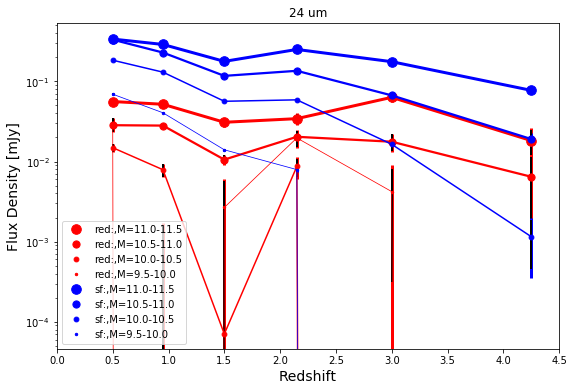

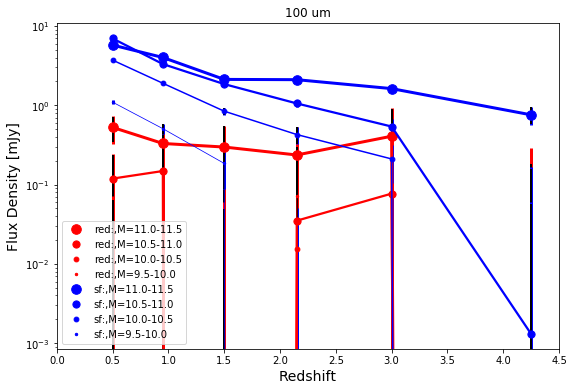

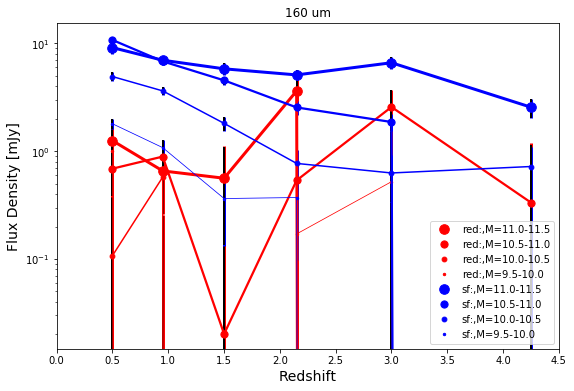

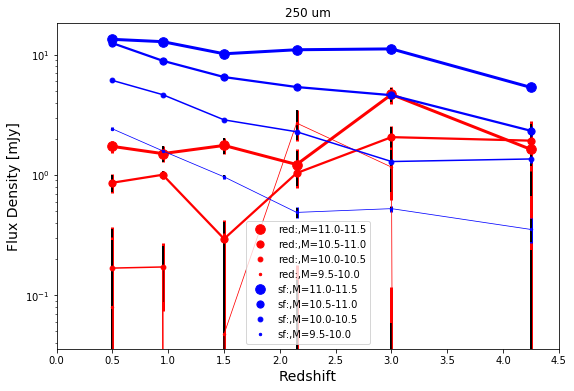

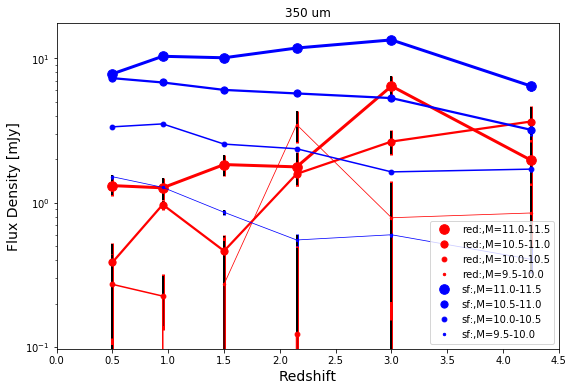

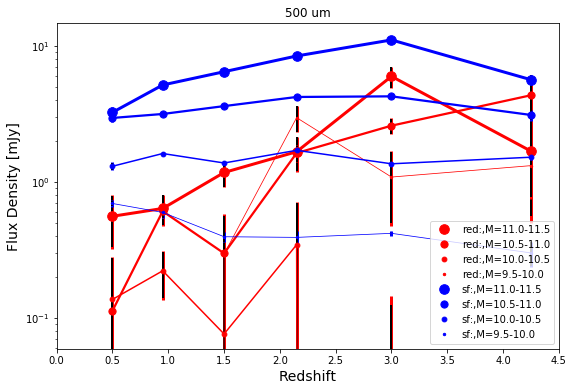

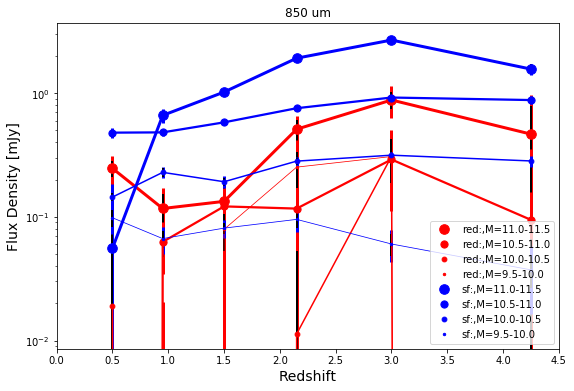

In [18]:
#Plot stacked results Flux vs Z, M, SF/QT
stagger_z = stagger_x(z_mid, nm, wid=0.025, log=True)
wv_mod = np.linspace(20,1000,100)

for iwv in range(nwv):
    wv = wvs[iwv]
    plt.figure(figsize=(9,6))
    plt.title(str(int(wv))+' um')
    plt.yscale('log')
    #plt.xscale('log')
    plt.xlim([0.0,4.5])
    plt.ylabel('Flux Density [mJy]',fontsize=14)
    plt.xlabel('Redshift',fontsize=14)
    
    for k in range(npop)[:]:
        for j in range(nm)[::-1]: 
            mn = m_nodes[j:j+2]

            xplot= [z[j] for z in stagger_z]
            plt.plot(z_mid,1e3*stacked_flux_densities.simstack_flux_array[iwv,:,j,k],'o',color=popcolor[k],label=pop[k]+':,M='+str(mn[0])+'-'+str(mn[1]),markersize=2.4*(j+1))
            plt.plot(z_mid,1e3*stacked_flux_densities.simstack_flux_array[iwv,:,j,k],color=popcolor[k],linewidth=0.75*(j+1))
            
            plt.errorbar(z_mid,1e3*stacked_flux_densities.simstack_flux_array[iwv,:,j,k],yerr=1e3*np.sqrt(stacked_flux_densities.simstack_error_array[iwv,:,j,k]**2+boot_errs.boot_error_bars[iwv,:,j,k]**2),fmt=None,ecolor=popcolor[k],elinewidth=3)
            plt.errorbar(z_mid,1e3*stacked_flux_densities.simstack_flux_array[iwv,:,j,k],yerr=1e3*boot_errs.boot_error_bars[iwv,:,j,k],fmt=None,ecolor='black',elinewidth=2)#,marker='o',markersize=12)
        plt.legend()
                
    plt.show()

/home/marcoviero/Code/Python/Modules/Utils/utils.py:519: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if covar == None:


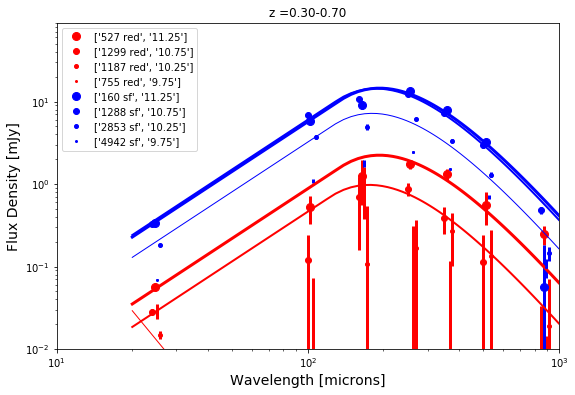

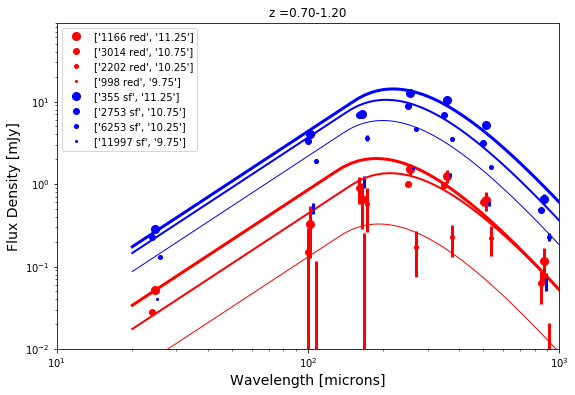

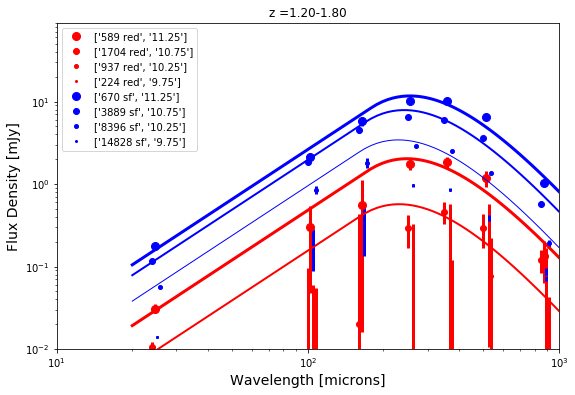

/home/marcoviero/Code/Python/Modules/Utils/utils.py:88: RuntimeWarning: overflow encountered in exp
  den = np.exp(a1 * np.outer(1.0/T,nu_in)) - 1.0


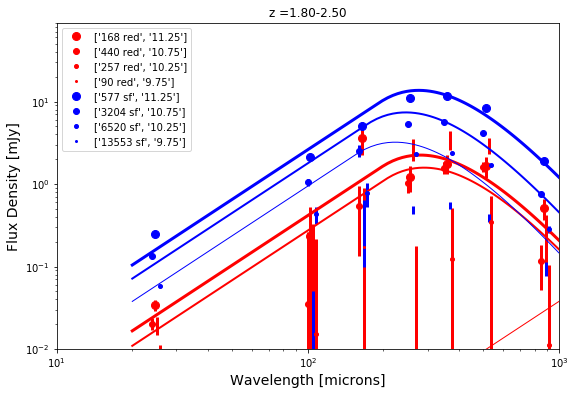

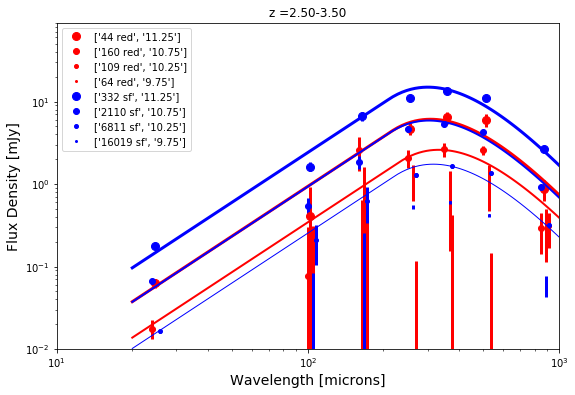

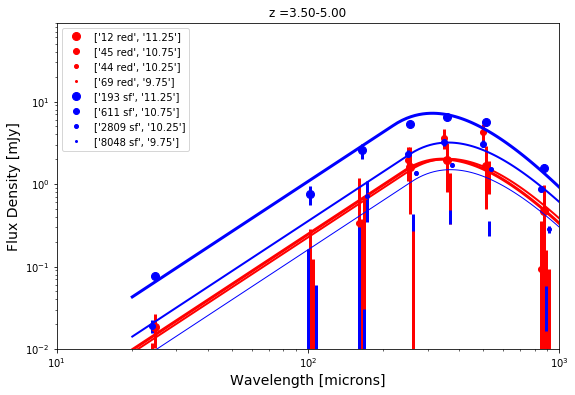

In [19]:
#Plot stacked results Flux vs Z, M, SF/QT
stagger_wvs = stagger_x(wvs, nm, wid=0.025, log=True)
wv_mod = np.linspace(20,1000,100)
for iz in range(nz):
    zn = z_nodes[iz:iz+2]
    z_suf = '{:.2f}'.format(zn[0])+'-'+'{:.2f}'.format(zn[1])
    #print zn
    
    #pdb.set_trace()
    #PLOT
    plt.figure(figsize=(9,6))
    plt.title('z =' +'{:.2f}'.format(zn[0])+'-'+'{:.2f}'.format(zn[1]))
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim([-1e-1,3e0])
    plt.ylim([1e-2,9e1])
    plt.xlim([10,1000])
    plt.ylabel('Flux Density [mJy]',fontsize=14)
    plt.xlabel('Wavelength [microns]',fontsize=14)
    #ln=['--','--','','','.-']
    for k in range(npop):
        for j in range(nm)[::-1]: 
            mn = m_nodes[j:j+2]
            #m_suf = str(mn[0])+'-'+str(mn[1])
            m_suf = '{:.2f}'.format(mn[0])+'-'+'{:.2f}'.format(mn[1])

            arg = clean_args('z_'+z_suf+'__m_'+m_suf+'_'+pop[k])
            ngal_bin = len(stacked_flux_densities.bin_ids[arg])

            if ngal_bin > 0:
                flux_wv = (all_stacked_fluxes[:,iz,j,k])
                flux_err= all_stacked_errors[:,iz,j,k]
                m = fast_sed_fitter(np.array(wvs),flux_wv,covar=flux_err)
                LIR = fast_Lir(m, np.mean(zn))
                ymod = fast_sed(m,wv_mod)
                xplot= [wv[j] for wv in stagger_wvs]
                #print xplot
                plt.plot(xplot,1e3*flux_wv,'o',color=popcolor[k],label=[str(ngal_bin)+' '+pop[k],str((m_nodes[j]+m_nodes[j+1])/2.0)],markersize=2*(j+1))
                #plt.plot(xplot,1e3*bootstrap_means[:,iz,j,k],'*',color='white',markersize=4*(j+1))
                plt.plot(wv_mod,1e3*ymod[0],color=popcolor[k],linewidth=j)#,label=str((1.0+z_mid[iz])*m['T_observed'].value))
                plt.errorbar(xplot,1e3*flux_wv,yerr=1e3*flux_err,fmt=None,ecolor=popcolor[k],elinewidth=3)#,marker='o',markersize=12)
    plt.legend()
                
    plt.show()
    #pdb.set_trace()